# PPE Detection Workflow

## 1. Exploratory Data Analysis (EDA)

### Import Libraries

In [1]:
import os
import random
import json
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from collections import Counter
import pandas as pd
from glob import glob

### Load and Explore the Dataset

In [2]:
import os

# Dataset path
BASE_PATH = "/kaggle/input/sh17-dataset-for-ppe-detection"
print(os.listdir(BASE_PATH))


['labels', 'train_files.txt', 'images', 'meta-data', 'val_files.txt', 'voc_labels']


In [3]:

# Paths
IMAGES_PATH = os.path.join(BASE_PATH, "images")
LABELS_PATH = os.path.join(BASE_PATH, "labels")
TRAIN_FILES = os.path.join(BASE_PATH, "train_files.txt")
VAL_FILES = os.path.join(BASE_PATH, "val_files.txt")

In [4]:
def list_files_in_folder(folder_path, extension):
    """List all files with a specific extension in a folder."""
    return sorted(glob(os.path.join(folder_path, f"*.{extension}")))

def load_metadata(metadata_path):
    """Load metadata JSON file."""
    with open(metadata_path, 'r') as f:
        return json.load(f)

def load_label(label_path):
    """Load YOLO label file and parse it."""
    with open(label_path, 'r') as f:
        lines = f.readlines()
    return [line.strip().split() for line in lines]

### Analyze All Class Distribution

* 0: person
* 1: ear
* 2: ear-mufs
* 3: face
* 4: face-guard
* 5: face-mask
* 6: foot
* 7: tool
* 8: glasses
* 9: gloves
* 10: helmet
* 11: hands
* 12: head
* 13: medical-suit
* 14: shoes
* 15: safety-suit
* 16: safety-vest

In [5]:
    
def analyze_class_distribution(labels_folder):
    """Analyze class distribution across all labels."""
    
    labels = list_files_in_folder(labels_folder, 'txt')
        
    class_instance_counter = Counter()
    class_image_counter = Counter()
  
    for label_file in labels:
        annotations = load_label(label_file)
        tmp_set = set()
        for annotation in annotations:
            class_id = annotation[0]
            class_instance_counter[class_id] += 1
            if class_id not in tmp_set : 
                class_image_counter[class_id] += 1
                tmp_set.add(class_id)
                
    # Create first DataFrame with instance counts
    df = pd.DataFrame(class_instance_counter.items(), columns=['Class_ID', 'Count Instances'])
    df['Class_ID'] = df['Class_ID'].astype(int)
    df = df.sort_values('Class_ID')
    
    # Create second DataFrame with image counts
    df_img_count = pd.DataFrame(class_image_counter.items(), columns=['Class_ID', 'Count Images'])
    df_img_count['Class_ID'] = df_img_count['Class_ID'].astype(int)
    df_img_count = df_img_count.sort_values('Class_ID')
    
    # Merge the DataFrames on Class_ID
    combined_df = pd.merge(df, df_img_count, on='Class_ID', how='outer')
    
    # Sort by Class_ID and reset index
    combined_df = combined_df.sort_values('Class_ID').reset_index(drop=True)
    
    return combined_df

Count the number of instances for each class and the number of images containing each class.

In [6]:

class_df = analyze_class_distribution(LABELS_PATH)
class_df.head()

,Class_ID,Count Instances,Count Images
0,0,13802,7617
1,1,7730,4884
2,2,318,223
3,3,8950,5646
4,4,134,127


In [7]:
def plot_class_distribution(df, class_names, figsize=(12, 6)):
    """Plot class distribution with percentages and colors."""
    # Calculate percentages
    total = df['Count'].sum()
    df['Percentage'] = (df['Count'] / total * 100).round(1)
    
    # Sort the DataFrame by counts in descending order
    df = df.sort_values('Count', ascending=False)
    
    # Map class IDs to their names
    df['Class_Name'] = df['Class_ID'].map(lambda x: class_names[int(x)])
    
    # Create the plot
    plt.figure(figsize=figsize)
    colors = sns.color_palette("husl", len(df))  
    barplot = sns.barplot(
        x='Class_Name', 
        y='Count', 
        data=df, 
        palette=colors
    )
    
    # Add percentage labels above the bars
    for i, row in enumerate(df.itertuples()):
        barplot.text(
            i, 
            row.Count + total * 0.003,  
            f"{row.Percentage}%", 
            ha='center', 
            fontsize=10, 
            color='black'
        )
    
    # Add labels and title
    plt.xlabel("Categories", fontsize=12)
    plt.ylabel("Instances", fontsize=12)
    plt.title("Class Distribution with Percentages", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

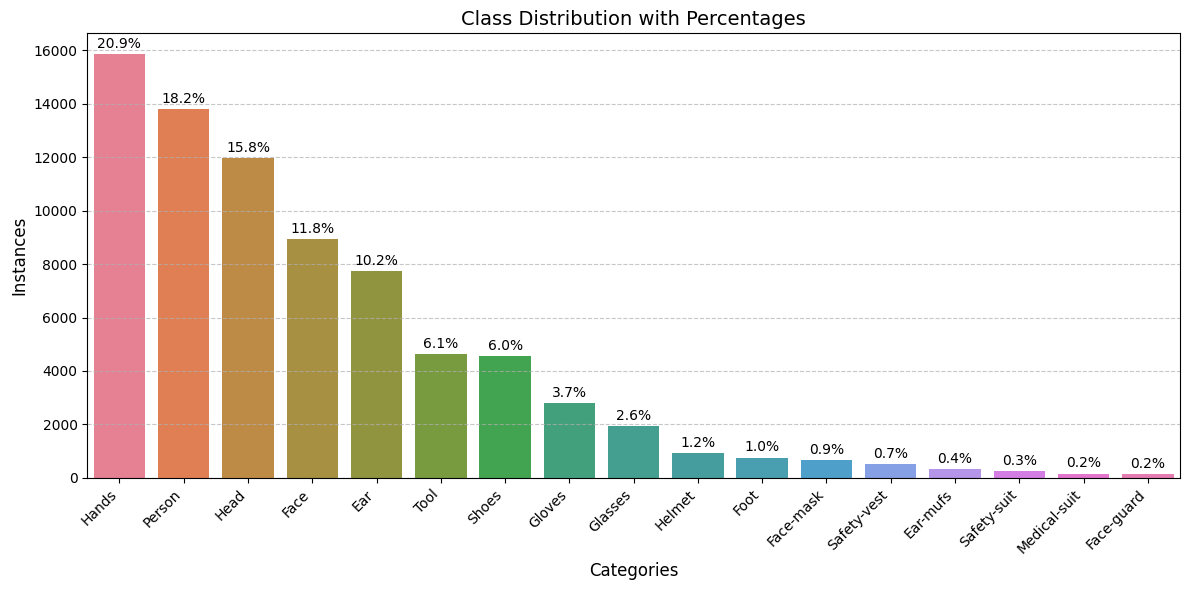

In [8]:
class_names = [
    "Person", "Ear", "Ear-mufs", "Face", "Face-guard", "Face-mask",
    "Foot", "Tool", "Glasses", "Gloves", "Helmet", "Hands", "Head",
    "Medical-suit", "Shoes", "Safety-suit", "Safety-vest"
]
plot_class_distribution(class_df.rename(columns={'Count Instances': 'Count'}), class_names)

Visualize a sample of the data with annotations.

In [9]:
def visualize_annotations(image_path, label_path, title=''):
    """Display an image with its bounding boxes."""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    annotations = load_label(label_path)
    for annotation in annotations:
        class_id, x_center, y_center, width, height = map(float, annotation)
        h, w, _ = img.shape
        xmin = int((x_center - width / 2) * w)
        ymin = int((y_center - height / 2) * h)
        xmax = int((x_center + width / 2) * w)
        ymax = int((y_center + height / 2) * h)
        
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(img, str(int(class_id)), (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()


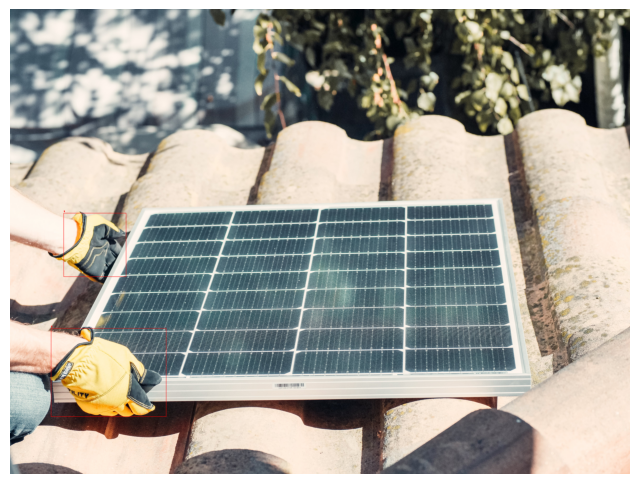

In [10]:
sample_image = f'{IMAGES_PATH}/pexels-photo-9875413.jpeg'
sample_label = f'{LABELS_PATH}/pexels-photo-9875413.txt'
visualize_annotations(sample_image, sample_label)


Zoom in on the class distribution to show only the person, helmet, and safety vest classes.

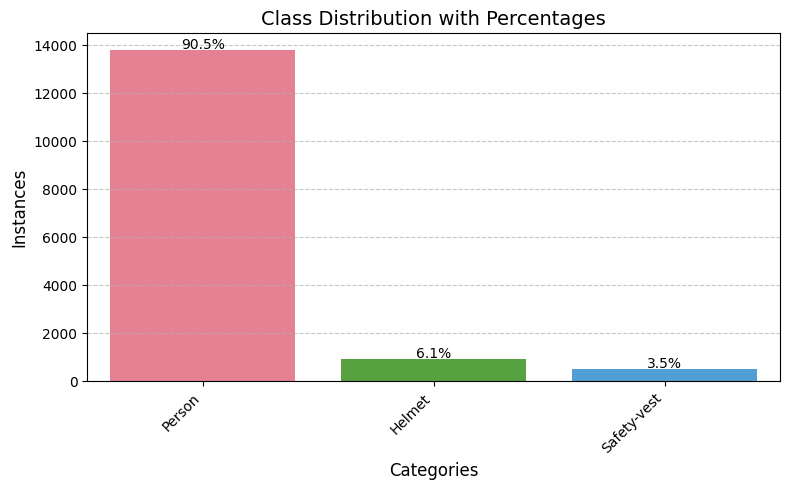

In [11]:
filtered_df = class_df[class_df['Class_ID'].isin([0, 10, 16])].copy()
plot_class_distribution(filtered_df.rename(columns={'Count Instances': 'Count'}), class_names, figsize=(8, 5))

## 2. Dataset Filtering

In [12]:
import os
import shutil

# Output directories for YOLO dataset structure
os.makedirs("/kaggle/working/dataset/images/train", exist_ok=True)
os.makedirs("/kaggle/working/dataset/images/val", exist_ok=True)
os.makedirs("/kaggle/working/dataset/labels/train", exist_ok=True)
os.makedirs("/kaggle/working/dataset/labels/val", exist_ok=True)

# Classes to retain: person (0), helmet (10), safety-vest (16)
TARGET_CLASSES = [0, 10, 16]

# Helper function to filter labels and move corresponding images
def filter_and_move(file_list, dest_images, dest_labels):
    with open(file_list, "r") as f:
        file_names = f.read().strip().split("\n")
    number_skip, number_move = 0, 0
    
    for file_name in file_names:
        base_name = os.path.splitext(file_name)[0]
        
        # Paths for source image and label
        img_src = os.path.join(IMAGES_PATH, file_name)
        label_src = os.path.join(LABELS_PATH, f"{base_name}.txt")
        
        # Skip if label does not exist
        if not os.path.exists(label_src):
            print(f"label does not exist {label_src}")
            continue

        # Read and filter label file
        filtered_lines = []
        with open(label_src, "r") as infile:
            for line in infile:
                class_id, *bbox = line.strip().split()
                if int(class_id) in TARGET_CLASSES:
                    # Map old class ID to new class ID (0, 1, 2)
                    new_class_id = TARGET_CLASSES.index(int(class_id))
                    filtered_lines.append(f"{new_class_id} {' '.join(bbox)}\n")  # Added \n here
        
        # Skip if no valid annotations remain
        if len(filtered_lines) == 0:
            number_skip += 1
            continue
            
        number_move += 1
        
        # Save filtered label
        label_dest = os.path.join(dest_labels, f"{base_name}.txt")
        with open(label_dest, "w") as outfile:
            outfile.writelines(filtered_lines)  # Now each line has proper line ending
        
        # Copy corresponding image
        shutil.copy2(img_src, os.path.join(dest_images, file_name))  # Fixed image copy path
    
    print(f"{number_skip} images skipped, and {number_move} were moved")

In [13]:
# Process training and validation datasets
filter_and_move(TRAIN_FILES, 
                "/kaggle/working/dataset/images/train", 
                "/kaggle/working/dataset/labels/train")



365 images skipped, and 6114 were moved


In [14]:
filter_and_move(VAL_FILES, 
                "/kaggle/working/dataset/images/val", 
                "/kaggle/working/dataset/labels/val")

100 images skipped, and 1520 were moved


In [15]:
filtered_class_df = analyze_class_distribution('/kaggle/working/dataset/labels/train')
filtered_class_df.head()

,Class_ID,Count Instances,Count Images
0,0,11068,6102
1,1,773,373
2,2,433,168


In [16]:
filtered_class_df_val = analyze_class_distribution('/kaggle/working/dataset/labels/val')
filtered_class_df_val.head()

,Class_ID,Count Instances,Count Images
0,0,2734,1515
1,1,154,93
2,2,97,45


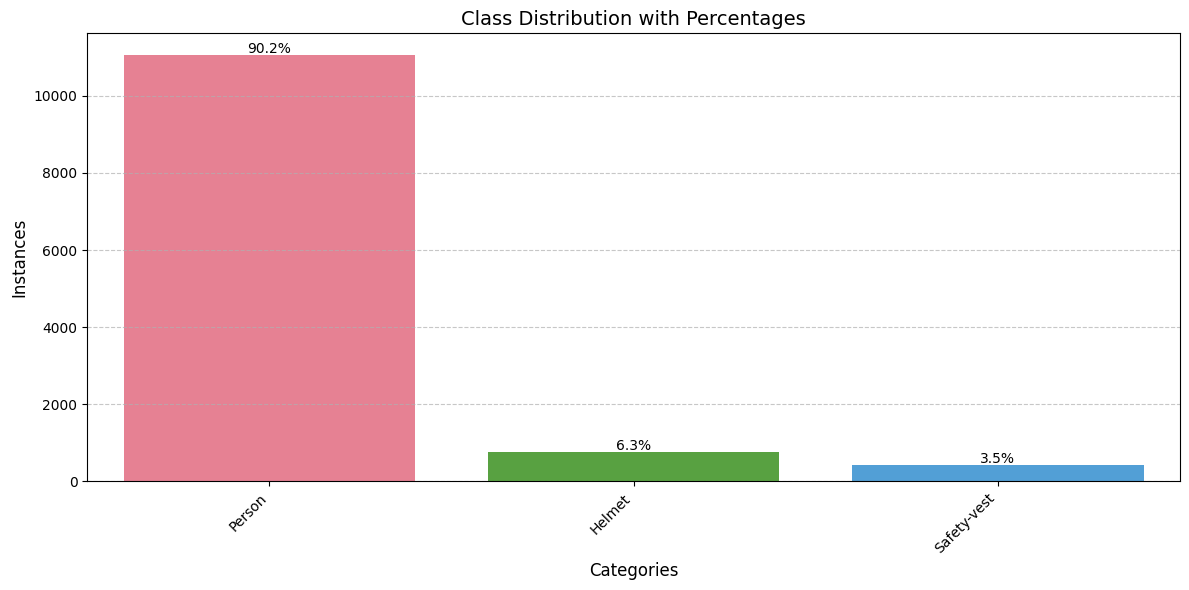

In [17]:
safety_class_names = [
    "Person", "Helmet","Safety-vest"
]
plot_class_distribution(filtered_class_df.rename(columns={'Count Instances': 'Count'}), safety_class_names)

## 3. Imbalanced Data

In [18]:
import os
import shutil

# Output directories for YOLO dataset structure
os.makedirs("/kaggle/working/undersampled_dataset/images/train", exist_ok=True)
os.makedirs("/kaggle/working/undersampled_dataset/images/val", exist_ok=True)
os.makedirs("/kaggle/working/undersampled_dataset/labels/train", exist_ok=True)
os.makedirs("/kaggle/working/undersampled_dataset/labels/val", exist_ok=True)

def undersampled_person_data( images_path, labels_path, dest_images, dest_labels, person_count):
    
    file_names = os.listdir(images_path)
    
    i= 0
    for file_name in file_names:
        
        base_name = os.path.splitext(file_name)[0]
        
        # Paths for source image and label
        img_src = os.path.join(images_path, file_name)
        label_src = os.path.join(labels_path, f"{base_name}.txt")
        
        # Skip if label does not exist
        if not os.path.exists(label_src):
            print(f"label does not exist {label_src}")
            continue

        filtered_lines = set()
        with open(label_src, "r") as infile:
            for line in infile:
                class_id, *bbox = line.strip().split()
                filtered_lines.add(int(class_id))
                
        filtered_lines = list(filtered_lines)            
        
        if len(filtered_lines) == 1 and filtered_lines[0] == 0 and i>= person_count:
            continue
        if len(filtered_lines) == 1 and filtered_lines[0] == 0:
            i+=1
         
        label_dest = os.path.join(dest_labels, f"{base_name}.txt")
        shutil.copy2(label_src, label_dest)
        
        # Copy corresponding image
        shutil.copy2(img_src, dest_images)
        



In [19]:
undersampled_person_data("/kaggle/working/dataset/images/train", 
                "/kaggle/working/dataset/labels/train", 
                "/kaggle/working/undersampled_dataset/images/train", 
                "/kaggle/working/undersampled_dataset/labels/train", 90)

In [20]:
undersampled_class_df = analyze_class_distribution('/kaggle/working/undersampled_dataset/labels/train')
undersampled_class_df.head()

,Class_ID,Count Instances,Count Images
0,0,1274,500
1,1,773,373
2,2,433,168


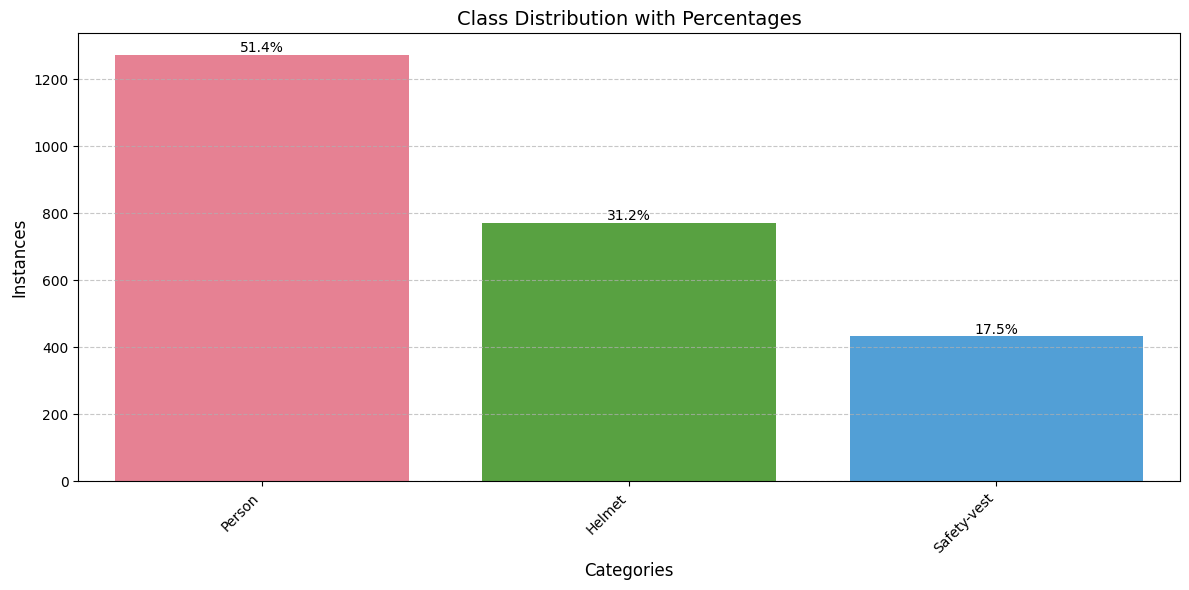

In [21]:
plot_class_distribution(undersampled_class_df.rename(columns={'Count Instances': 'Count'}), safety_class_names)

In [22]:
undersampled_person_data("/kaggle/working/dataset/images/val", 
                "/kaggle/working/dataset/labels/val", 
                "/kaggle/working/undersampled_dataset/images/val", 
                "/kaggle/working/undersampled_dataset/labels/val", 30)

In [23]:
undersampled_class_df_val = analyze_class_distribution('/kaggle/working/undersampled_dataset/labels/val')
undersampled_class_df_val.head()

,Class_ID,Count Instances,Count Images
0,0,307,131
1,1,154,93
2,2,97,45


## 4. Model Training

In [24]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [25]:
data_yaml = """
train: /kaggle/working/undersampled_dataset/images/train
val: /kaggle/working/undersampled_dataset/images/val
names:
  0: person
  1: helmet
  2: safety-vest
"""

with open("/kaggle/working/data.yaml", "w") as f:
    f.write(data_yaml)


In [26]:
from ultralytics import YOLO
import torch
torch.cuda.empty_cache()
model = YOLO("yolov10m.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [27]:
print("CUDA Available:", torch.cuda.is_available())
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


CUDA Available: True
Device Name: Tesla P100-PCIE-16GB


In [29]:
model.train(
    data="/kaggle/working/data.yaml",
    project="/kaggle/working/runs",
    batch=16,
    epochs=50,
    imgsz=640,
    # cache=True,
    optimizer = 'AdamW',
    lr0 = 1e-3
    # lrf = 0.01,
    # weight_decay = 5e-4,
    # dropout = 0.2, 
    # patience = 100, 
    # label_smoothing = 0.0 
)

Ultralytics 8.3.221 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=0.0, plots=True,

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c1c05aaa710>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [30]:
model = YOLO('/kaggle/working/runs/train/weights/best.pt')
model.export(format='onnx')  


Ultralytics 8.3.221 🚀 Python-3.10.13 torch-2.1.2 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLOv10m summary (fused): 136 layers, 15,314,905 parameters, 0 gradients, 58.9 GFLOPs

PyTorch: starting from '/kaggle/working/runs/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 300, 6) (95.2 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/165.3 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.3/165.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/300.5 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/300.5 MB 49.2 MB/s eta 0:00:07
   ━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/300.5 MB 120.8 MB/s eta 0:00:03
   ━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17

'/kaggle/working/runs/train/weights/best.onnx'

## 5. Evaluation

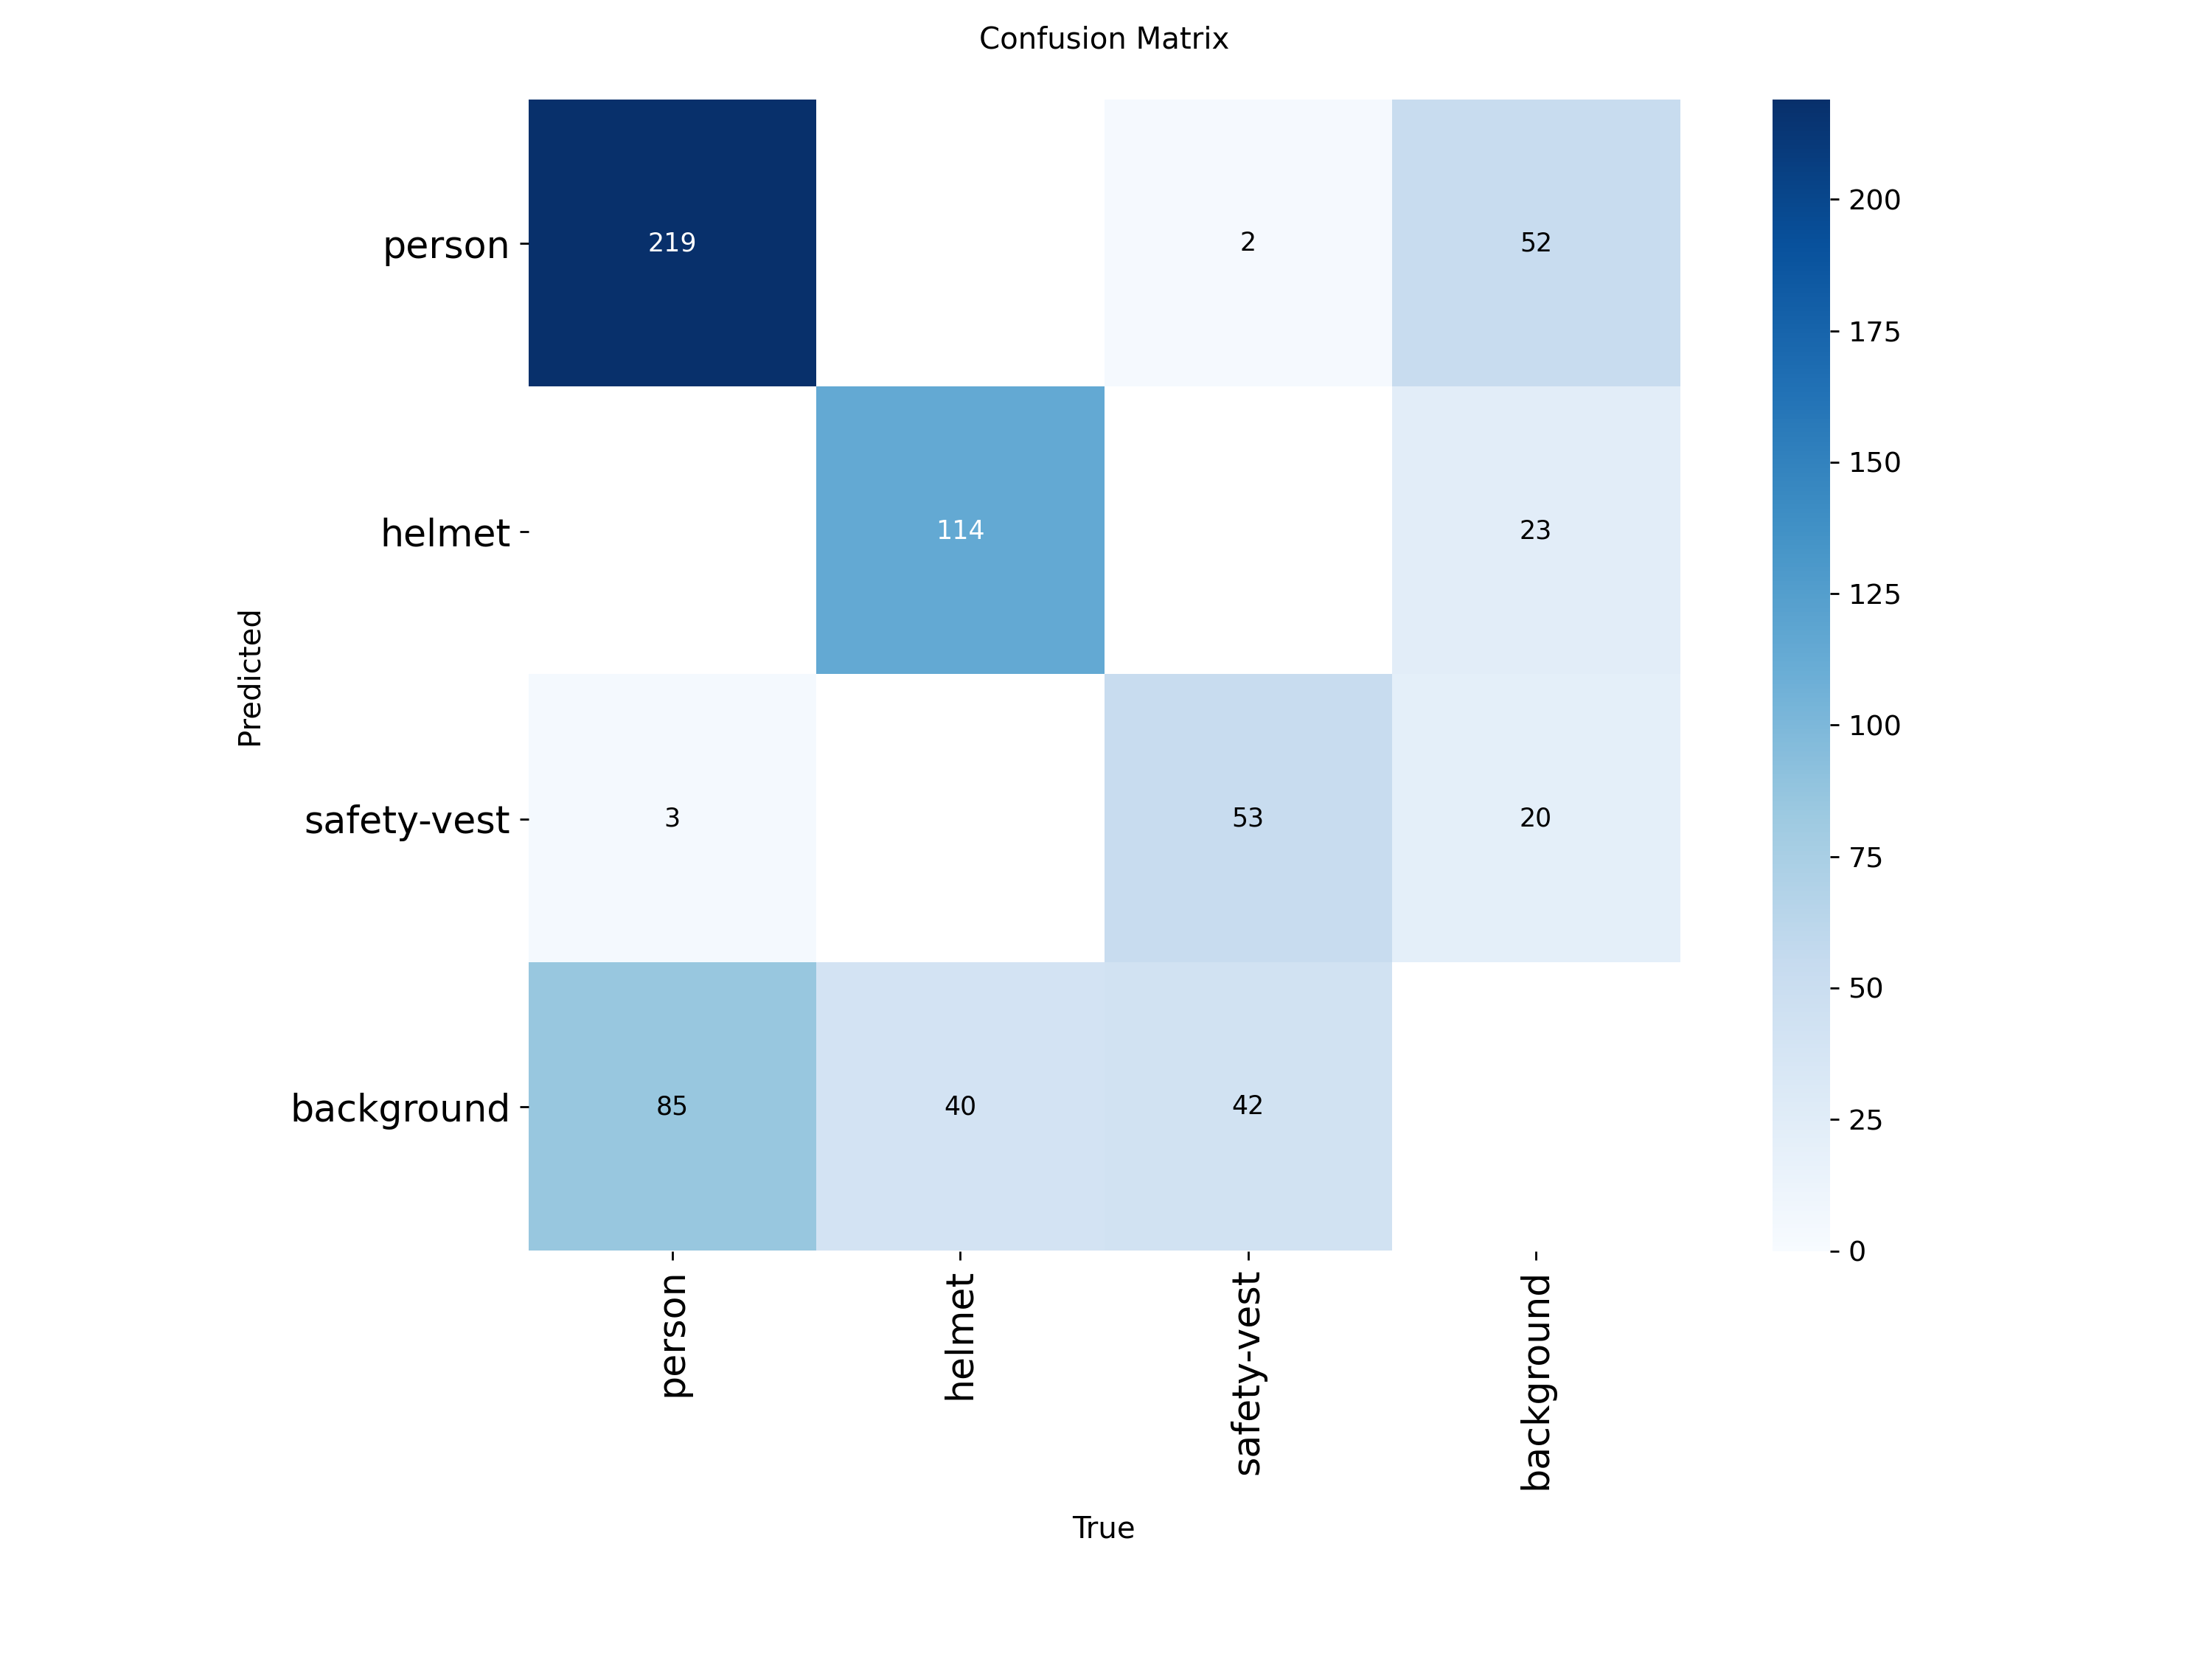

In [32]:
from IPython.display import Image
Image(filename='/kaggle/working/runs/train2/confusion_matrix.png', width=800)

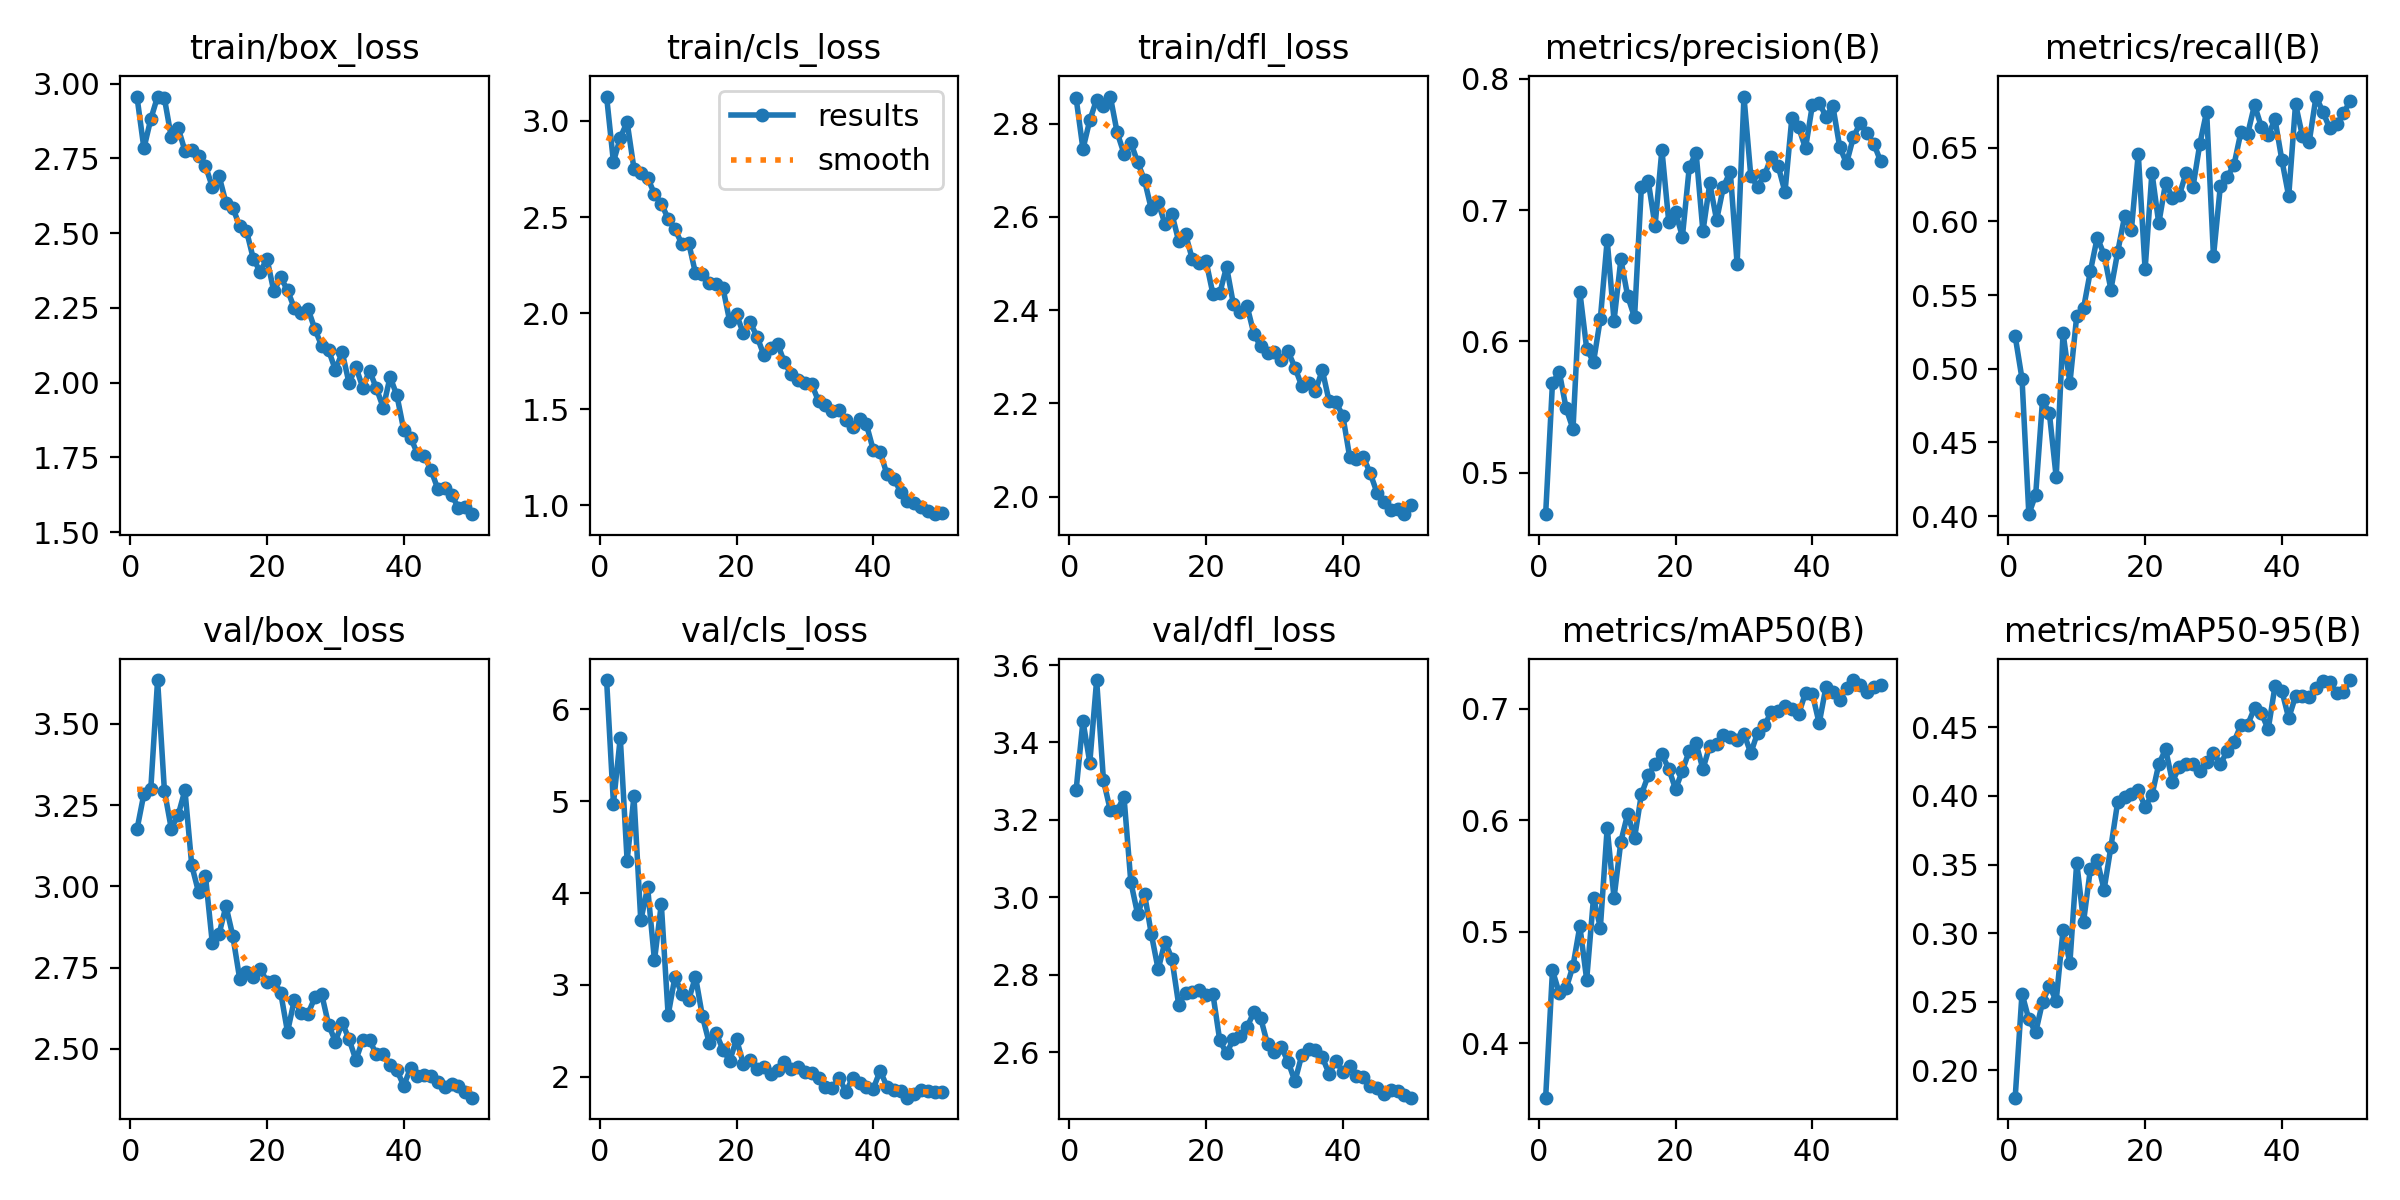

In [33]:
Image(filename='/kaggle/working/runs/train2/results.png', width=800)

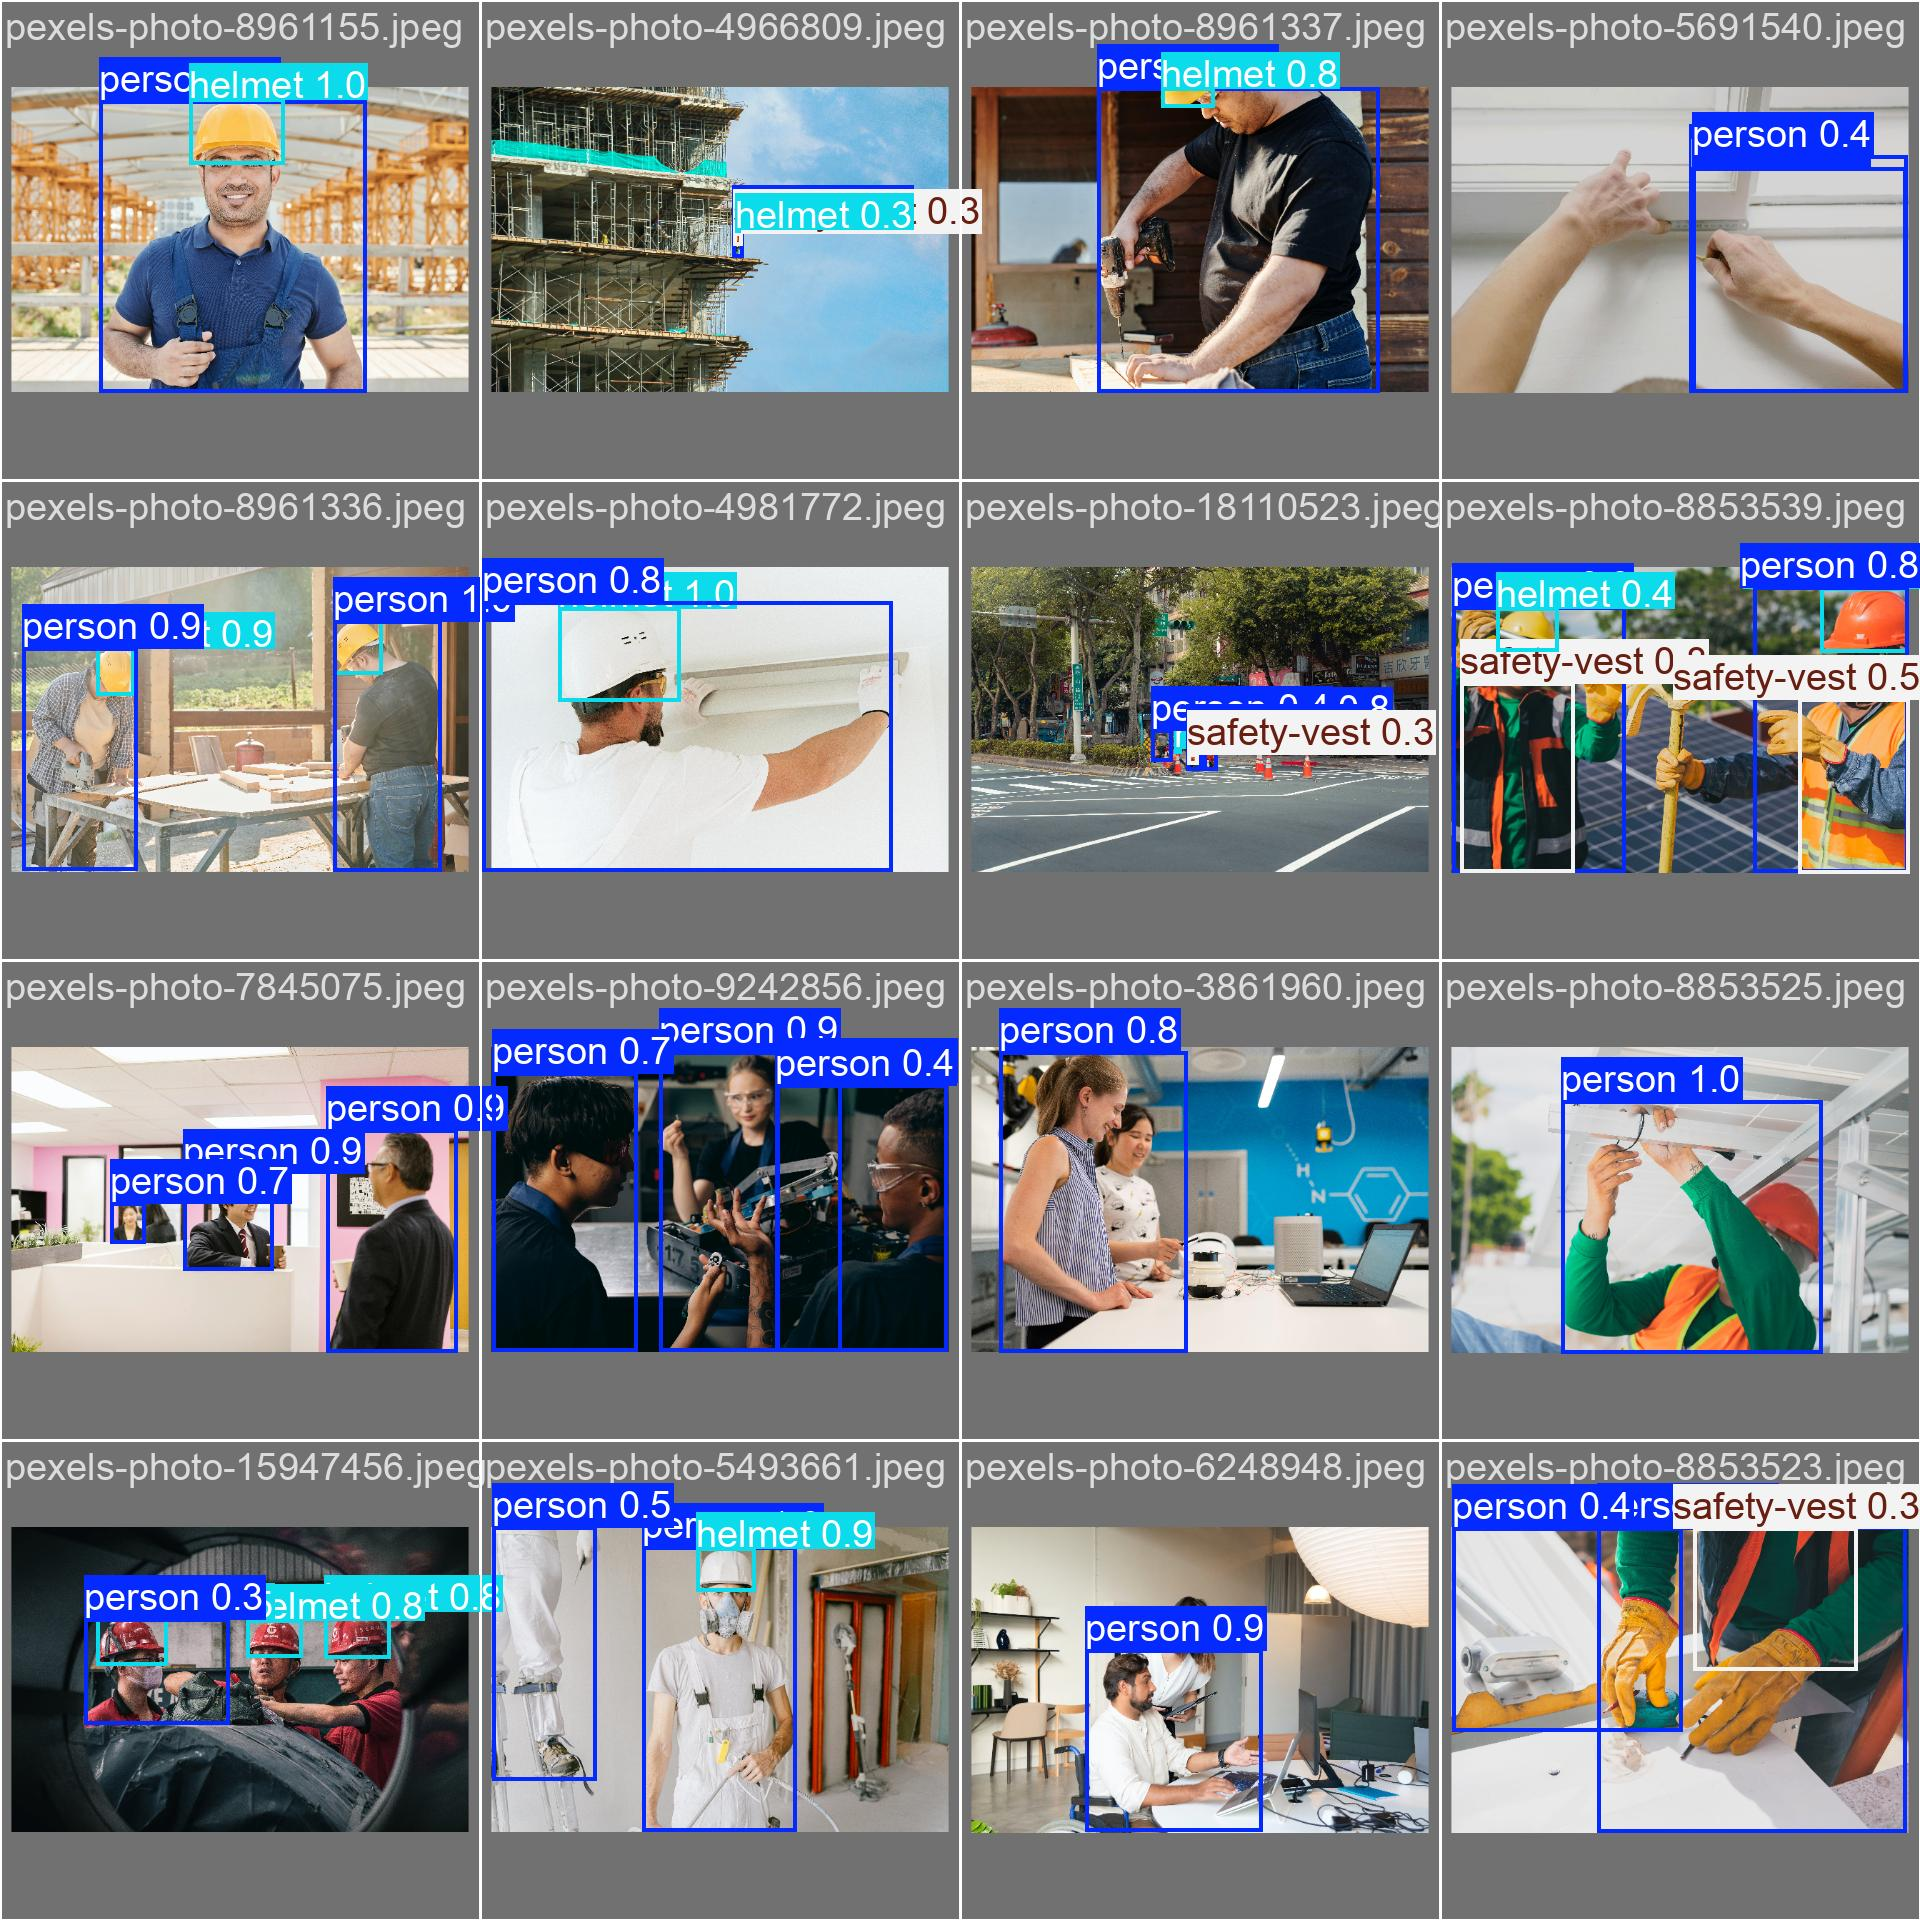

In [34]:
Image(filename='/kaggle/working/runs/train2/val_batch2_pred.jpg', width=800)

* Test the model with a real image:

* Display a sample test image.
* Show the detected bounding boxes.
* Display the labels corresponding to the detected objects.


image 1/1 /kaggle/input/safety-helmet-test-dataset/test_dataset/test_image.jpeg: 384x640 5 persons, 5 helmets, 70 safety-vests, 63.2ms
Speed: 2.2ms preprocess, 63.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
80 bounding boxes drawn.


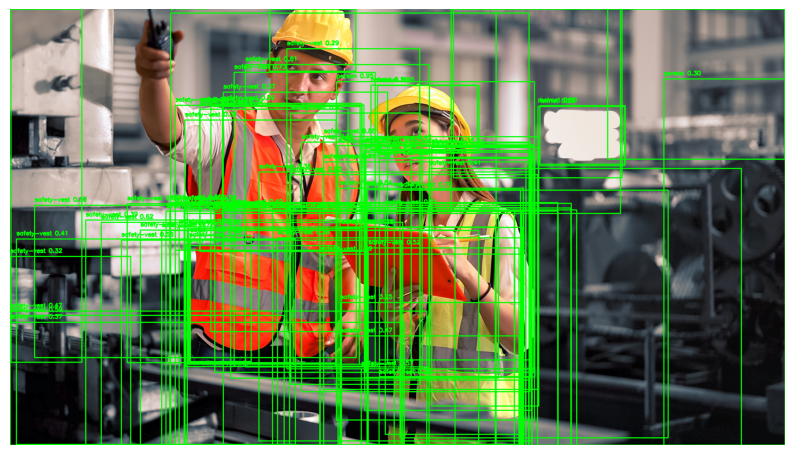

In [35]:
import cv2
import matplotlib.pyplot as plt
import os

# Path to the image
test_image_path = '/kaggle/input/safety-helmet-test-dataset/test_dataset/test_image.jpeg'

# Perform inference
results = model.predict(source=test_image_path, conf=0.25)  

# Check if results are available
if not results:
    print("No detection results found.")
    exit()

# Load the image
image = cv2.imread(test_image_path)

# Ensure the image is loaded
if image is None:
    raise ValueError("Failed to load the image. Check the file path.")

# Draw bounding boxes on the image
boxes_drawn = 0
for result in results:
    if not result.boxes:
        print("No bounding boxes detected.")
        continue

    for box, conf, cls in zip(result.boxes.xyxy, result.boxes.conf, result.boxes.cls):
        x1, y1, x2, y2 = map(int, box)  # Bounding box coordinates
        confidence = float(conf)  # Confidence score
        class_id = int(cls)  # Class ID
        label = f"{model.names[class_id]} {confidence:.2f}"

        # Draw the bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # Put the label on the image
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        boxes_drawn += 1

# Check if any boxes were drawn
if boxes_drawn == 0:
    print("No bounding boxes were drawn. Try lowering the confidence threshold or using a different image.")
else:
    print(f"{boxes_drawn} bounding boxes drawn.")

# Convert the image to RGB for displaying with matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis("off")
plt.show()


In [38]:
# Zip the entire folder
!zip -r /kaggle/working/train2.zip /kaggle/working/runs/train2

# Create a clickable download link
from IPython.display import FileLink
FileLink('/kaggle/working/train2.zip')

updating: kaggle/working/runs/train2/ (stored 0%)
updating: kaggle/working/runs/train2/val_batch1_pred.jpg (deflated 5%)
updating: kaggle/working/runs/train2/train_batch2.jpg (deflated 3%)
updating: kaggle/working/runs/train2/args.yaml (deflated 53%)
updating: kaggle/working/runs/train2/val_batch1_labels.jpg (deflated 6%)
updating: kaggle/working/runs/train2/train_batch1280.jpg (deflated 11%)
updating: kaggle/working/runs/train2/results.png (deflated 7%)
updating: kaggle/working/runs/train2/labels.jpg (deflated 32%)
updating: kaggle/working/runs/train2/BoxP_curve.png (deflated 10%)
updating: kaggle/working/runs/train2/val_batch2_labels.jpg (deflated 13%)
updating: kaggle/working/runs/train2/results.csv (deflated 59%)
updating: kaggle/working/runs/train2/val_batch0_labels.jpg (deflated 6%)
updating: kaggle/working/runs/train2/train_batch1.jpg (deflated 2%)
updating: kaggle/working/runs/train2/train_batch1281.jpg (deflated 9%)
updating: kaggle/working/runs/train2/confusion_matrix.png (de

/kaggle/working/train2.zip